# Load the libraries

In [7]:
library(data.table);
library(ggplot2);
library(repr)
library(reshape2)
##library(gplots)
library(pheatmap)
library(cowplot)
library(RColorBrewer)
library(sva)
##library(ggExtra)
library("e1071")
library('glmnet')

source("helper_functions.R")

In [8]:
options(repr.plot.width = 3, repr.plot.height = 3, repr.plot.res=80)
name <- "CLUESImmVar_processed.V6.1";

version <- "V6.1";

# Load the necessary input

## Load the covariates from ```/ye/yelabstore2/10x.lupus/eqtls/demux.v2```

In [9]:
## start with pdcs since there's one person without any
pdc_covs <- fread("v6.1.expr/v6.1.full.pDC.blind.covs.txt");
colnames(pdc_covs) <- sapply(colnames(pdc_covs), function(x) {strsplit(x,"_")[[1]][[1]]})
covs_gene_names <- pdc_covs$V1;
pdc_covs <- as.matrix(pdc_covs[,-1]);

cm_covs <- as.matrix(fread("v6.1.expr/v6.1.full.cM.blind.covs.txt")[,-1]);
colnames(cm_covs) <- sapply(colnames(cm_covs), function(x) {strsplit(x,"_")[[1]][[1]]})
cm_covs <- cm_covs[match(pdc_covs[,"sample"], cm_covs[,"sample"]),];

th_covs <- as.matrix(fread("v6.1.expr/v6.1.full.Th.blind.covs.txt")[,-1]);
colnames(th_covs) <- sapply(colnames(th_covs), function(x) {strsplit(x,"_")[[1]][[1]]})
th_covs <- th_covs[match(pdc_covs[,"sample"], th_covs[,"sample"]),];

tc_covs <- as.matrix(fread("v6.1.expr/v6.1.full.Tc.blind.covs.txt")[,-1]);
colnames(tc_covs) <- sapply(colnames(tc_covs), function(x) {strsplit(x,"_")[[1]][[1]]})
tc_covs <- tc_covs[match(pdc_covs[,"sample"], tc_covs[,"sample"]),];

ncm_covs <- as.matrix(fread("v6.1.expr/v6.1.full.ncM.blind.covs.txt")[,-1]);
colnames(ncm_covs) <- sapply(colnames(ncm_covs), function(x) {strsplit(x,"_")[[1]][[1]]})
ncm_covs <- ncm_covs[match(pdc_covs[,"sample"], ncm_covs[,"sample"]),];

b_covs <- as.matrix(fread("v6.1.expr/v6.1.full.B.blind.covs.txt")[,-1]);
colnames(b_covs) <- sapply(colnames(b_covs), function(x) {strsplit(x,"_")[[1]][[1]]})
b_covs <- b_covs[match(pdc_covs[,"sample"], b_covs[,"sample"]),];

nk_covs <- as.matrix(fread("v6.1.expr/v6.1.full.NK.blind.covs.txt")[,-1]);
colnames(nk_covs) <- sapply(colnames(nk_covs), function(x) {strsplit(x,"_")[[1]][[1]]})
nk_covs <- nk_covs[match(pdc_covs[,"sample"], nk_covs[,"sample"]),];

cdc_covs <- as.matrix(fread("v6.1.expr/v6.1.full.cDC.blind.covs.txt")[,-1]);
colnames(cdc_covs) <- sapply(colnames(cdc_covs), function(x) {strsplit(x,"_")[[1]][[1]]})
cdc_covs <- cdc_covs[match(pdc_covs[,"sample"], cdc_covs[,"sample"]),];

pbmc_covs <- as.matrix(fread("v6.1.expr/v6.1.full.PBMC.blind.covs.txt")[,-1]);
colnames(pbmc_covs) <- sapply(colnames(pbmc_covs), function(x) {strsplit(x,"_")[[1]][[1]]})
pbmc_covs <- pbmc_covs[match(pdc_covs[,"sample"], pbmc_covs[,"sample"]),];

# pbmc_covs <- as.matrix(fread("v5.expr/v5.full.PBMC.blind.covs.txt")[,-1]);
# colnames(pbmc_covs) <- sapply(colnames(pbmc_covs), function(x) {strsplit(x,"_")[[1]][[1]]})

rownames(pbmc_covs) <- rownames(cm_covs) <- rownames(th_covs) <- rownames(tc_covs) <- rownames(ncm_covs) <- rownames(b_covs) <- rownames(nk_covs) <-rownames(cdc_covs) <- rownames(pdc_covs)<- covs_gene_names;


## Load the processed expression data from ```/ye/yelabstore2/10x.lupus/eqtls/demux.v2```

In [10]:
pdc_expr <- fread("v6.1.expr/v6.1.full.pDC.blind.expr.txt");
colnames(pdc_expr) <- sapply(colnames(pdc_expr), function(x) {a <- strsplit(x,"_"); if(length(a[[1]])==3) {return(paste(a[[1]][2:3],collapse="_"))} else {return(paste(a[[1]][1:2],collapse="_"))}})
expr_gene_names <- pdc_expr$V1;
pdc_expr <- as.matrix(pdc_expr[,-1]);

th_expr <- as.matrix(fread("v6.1.expr/v6.1.full.Th.blind.expr.txt")[,-1]);
colnames(th_expr) <- sapply(colnames(th_expr), function(x) {a <- strsplit(x,"_"); if(length(a[[1]])==3) {return(paste(a[[1]][2:3],collapse="_"))} else {return(paste(a[[1]][1:2],collapse="_"))}})
th_expr <- th_expr[,colnames(pdc_expr)];

tc_expr <- as.matrix(fread("v6.1.expr/v6.1.full.Tc.blind.expr.txt")[,-1]);
colnames(tc_expr) <- sapply(colnames(tc_expr), function(x) {a <- strsplit(x,"_"); if(length(a[[1]])==3) {return(paste(a[[1]][2:3],collapse="_"))} else {return(paste(a[[1]][1:2],collapse="_"))}})
tc_expr <- tc_expr[,colnames(pdc_expr)];

ncm_expr <- as.matrix(fread("v6.1.expr/v6.1.full.ncM.blind.expr.txt")[,-1]);
colnames(ncm_expr) <- sapply(colnames(ncm_expr), function(x) {a <- strsplit(x,"_"); if(length(a[[1]])==3) {return(paste(a[[1]][2:3],collapse="_"))} else {return(paste(a[[1]][1:2],collapse="_"))}})
ncm_expr <- ncm_expr[,colnames(pdc_expr)];

b_expr <- as.matrix(fread("v6.1.expr/v6.1.full.B.blind.expr.txt")[,-1]);
colnames(b_expr) <- sapply(colnames(b_expr), function(x) {a <- strsplit(x,"_"); if(length(a[[1]])==3) {return(paste(a[[1]][2:3],collapse="_"))} else {return(paste(a[[1]][1:2],collapse="_"))}})
b_expr <- b_expr[,colnames(pdc_expr)];

nk_expr <- as.matrix(fread("v6.1.expr/v6.1.full.NK.blind.expr.txt")[,-1]);
colnames(nk_expr) <- sapply(colnames(nk_expr), function(x) {a <- strsplit(x,"_"); if(length(a[[1]])==3) {return(paste(a[[1]][2:3],collapse="_"))} else {return(paste(a[[1]][1:2],collapse="_"))}})
nk_expr <- nk_expr[,colnames(pdc_expr)];

cdc_expr <- as.matrix(fread("v6.1.expr/v6.1.full.cDC.blind.expr.txt")[,-1]);
colnames(cdc_expr) <- sapply(colnames(cdc_expr), function(x) {a <- strsplit(x,"_"); if(length(a[[1]])==3) {return(paste(a[[1]][2:3],collapse="_"))} else {return(paste(a[[1]][1:2],collapse="_"))}})
cdc_expr <- cdc_expr[,colnames(pdc_expr)];

cm_expr <- as.matrix(fread("v6.1.expr/v6.1.full.cM.blind.expr.txt")[,-1]);
colnames(cm_expr) <- sapply(colnames(cm_expr), function(x) {a <- strsplit(x,"_"); if(length(a[[1]])==3) {return(paste(a[[1]][2:3],collapse="_"))} else {return(paste(a[[1]][1:2],collapse="_"))}})
cm_expr <- cm_expr[,colnames(pdc_expr)];

pbmc_expr <- as.matrix(fread("v6.1.expr/v6.1.full.PBMC.blind.expr.txt")[,-1]);
colnames(pbmc_expr) <- sapply(colnames(pbmc_expr), function(x) {a <- strsplit(x,"_"); if(length(a[[1]])==3) {return(paste(a[[1]][2:3],collapse="_"))} else {return(paste(a[[1]][1:2],collapse="_"))}})
pbmc_expr <- pbmc_expr[,colnames(pdc_expr)];

rownames(pbmc_expr) <- rownames(cm_expr) <- rownames(th_expr) <- rownames(tc_expr) <- rownames(ncm_expr) <- rownames(b_expr) <- rownames(nk_expr) <-rownames(cdc_expr) <-rownames(pdc_expr) <- expr_gene_names;

## do a quick filter for all zeros
any_zeros = unique(c(which(rowSums(pbmc_expr) ==0),
                     which(rowSums(cm_expr)==0),
                     which(rowSums(ncm_expr)==0),
                     which(rowSums(th_expr)==0),
                     which(rowSums(tc_expr)==0),
                     which(rowSums(b_expr)==0),
                     which(rowSums(nk_expr)==0),
                     which(rowSums(cdc_expr)==0),
                     which(rowSums(pdc_expr)==0)))
pbmc_expr <- pbmc_expr[-any_zeros,];
cm_expr <- cm_expr[-any_zeros,];
ncm_expr <- ncm_expr[-any_zeros,];
th_expr <- th_expr[-any_zeros,];
tc_expr <- tc_expr[-any_zeros,];
b_expr <- b_expr[-any_zeros,];
nk_expr <- nk_expr[-any_zeros,];
cdc_expr <- cdc_expr[-any_zeros,];
pdc_expr <- pdc_expr[-any_zeros,];
expr_gene_names <- expr_gene_names[-any_zeros];


Warning message in fread("v6.1.expr/v6.1.full.pDC.blind.expr.txt"):
“Detected 205 column names but the data has 206 columns (i.e. invalid file). Added 1 extra default column name for the first column which is guessed to be row names or an index. Use setnames() afterwards if this guess is not correct, or fix the file write command that created the file to create a valid file.”Warning message in fread("v6.1.expr/v6.1.full.Th.blind.expr.txt"):
“Detected 206 column names but the data has 207 columns (i.e. invalid file). Added 1 extra default column name for the first column which is guessed to be row names or an index. Use setnames() afterwards if this guess is not correct, or fix the file write command that created the file to create a valid file.”Warning message in fread("v6.1.expr/v6.1.full.Tc.blind.expr.txt"):
“Detected 206 column names but the data has 207 columns (i.e. invalid file). Added 1 extra default column name for the first column which is guessed to be row names or an index. 

## load counts and standardize

In [11]:
pdc_counts <- fread("v6.1.expr/v6.1.full.pDC.blind.counts.txt");
colnames(pdc_counts) <- sapply(colnames(pdc_counts), function(x) {a <- strsplit(x,"_"); if(length(a[[1]])==3) {return(paste(a[[1]][2:3],collapse="_"))} else {return(paste(a[[1]][1:2],collapse="_"))}})
counts_gene_names <- pdc_counts$V1_NA;
pdc_counts <- as.matrix(pdc_counts[,-1]);
pdc_counts <- pdc_counts[match(expr_gene_names, counts_gene_names),]

pdc_expr_raw <- as.matrix(fread("v6.1.expr/v6.1.full.pDC.blind.expr.txt"))[,-1];
th_expr_raw <- as.matrix(fread("v6.1.expr/v6.1.full.Th.blind.expr.txt"))[,-1];
pdc_indices <- match(colnames(pdc_expr_raw), colnames(th_expr_raw));

th_counts <- as.matrix(fread("v6.1.expr/v6.1.full.Th.blind.counts.txt")[,-1]);
colnames(th_counts) <- sapply(colnames(th_counts), function(x) {a <- strsplit(x,"_"); if(length(a[[1]])==3) {return(paste(a[[1]][2:3],collapse="_"))} else {return(paste(a[[1]][1:2],collapse="_"))}})
th_counts <- th_counts[match(expr_gene_names, counts_gene_names),]
th_counts <- th_counts[,pdc_indices];

tc_counts <- as.matrix(fread("v6.1.expr/v6.1.full.Tc.blind.counts.txt")[,-1]);
colnames(tc_counts) <- sapply(colnames(tc_counts), function(x) {a <- strsplit(x,"_"); if(length(a[[1]])==3) {return(paste(a[[1]][2:3],collapse="_"))} else {return(paste(a[[1]][1:2],collapse="_"))}})
tc_counts <- tc_counts[match(expr_gene_names, counts_gene_names),]
tc_counts <- tc_counts[,pdc_indices];

ncm_counts <- as.matrix(fread("v6.1.expr/v6.1.full.ncM.blind.counts.txt")[,-1]);
colnames(ncm_counts) <- sapply(colnames(ncm_counts), function(x) {a <- strsplit(x,"_"); if(length(a[[1]])==3) {return(paste(a[[1]][2:3],collapse="_"))} else {return(paste(a[[1]][1:2],collapse="_"))}})
ncm_counts <- ncm_counts[match(expr_gene_names, counts_gene_names),]
ncm_counts <- ncm_counts[,pdc_indices];

b_counts <- as.matrix(fread("v6.1.expr/v6.1.full.B.blind.counts.txt")[,-1]);
colnames(b_counts) <- sapply(colnames(b_counts), function(x) {a <- strsplit(x,"_"); if(length(a[[1]])==3) {return(paste(a[[1]][2:3],collapse="_"))} else {return(paste(a[[1]][1:2],collapse="_"))}})
b_counts <- b_counts[match(expr_gene_names, counts_gene_names),]
b_counts <- b_counts[,pdc_indices];

nk_counts <- as.matrix(fread("v6.1.expr/v6.1.full.NK.blind.counts.txt")[,-1]);
colnames(nk_counts) <- sapply(colnames(nk_counts), function(x) {a <- strsplit(x,"_"); if(length(a[[1]])==3) {return(paste(a[[1]][2:3],collapse="_"))} else {return(paste(a[[1]][1:2],collapse="_"))}})
nk_counts <- nk_counts[match(expr_gene_names, counts_gene_names),]
nk_counts <- nk_counts[,pdc_indices];

cdc_counts <- as.matrix(fread("v6.1.expr/v6.1.full.cDC.blind.counts.txt")[,-1]);
colnames(cdc_counts) <- sapply(colnames(cdc_counts), function(x) {a <- strsplit(x,"_"); if(length(a[[1]])==3) {return(paste(a[[1]][2:3],collapse="_"))} else {return(paste(a[[1]][1:2],collapse="_"))}})
cdc_counts <- cdc_counts[match(expr_gene_names, counts_gene_names),]
cdc_counts <- cdc_counts[,pdc_indices];

cm_counts <- as.matrix(fread("v6.1.expr/v6.1.full.cM.blind.counts.txt")[,-1]);
colnames(cm_counts) <- sapply(colnames(cm_counts), function(x) {a <- strsplit(x,"_"); if(length(a[[1]])==3) {return(paste(a[[1]][2:3],collapse="_"))} else {return(paste(a[[1]][1:2],collapse="_"))}})
cm_counts <- cm_counts[match(expr_gene_names, counts_gene_names),]
cm_counts <- cm_counts[,pdc_indices];

pbmc_counts <- as.matrix(fread("v6.1.expr/v6.1.full.PBMC.blind.counts.txt")[,-1]);
colnames(pbmc_counts) <- sapply(colnames(pbmc_counts), function(x) {a <- strsplit(x,"_"); if(length(a[[1]])==3) {return(paste(a[[1]][2:3],collapse="_"))} else {return(paste(a[[1]][1:2],collapse="_"))}})
pbmc_counts <- pbmc_counts[match(expr_gene_names, counts_gene_names),]
pbmc_counts <- pbmc_counts[,pdc_indices];

rownames(pbmc_counts) <- rownames(cm_counts) <- rownames(th_counts) <- rownames(tc_counts) <- rownames(ncm_counts) <- rownames(b_counts) <- rownames(nk_counts) <-rownames(cdc_counts) <-rownames(pdc_counts) <- expr_gene_names;
colnames(pbmc_counts) <- colnames(cm_counts) <- colnames(th_counts) <- colnames(tc_counts) <- colnames(ncm_counts) <- colnames(b_counts) <- colnames(nk_counts) <-colnames(cdc_counts) <-colnames(pdc_counts) <- colnames(pbmc_expr)

# ## do a quick filter for all zeros
# any_zeros = unique(c(which(rowSums(pbmc_counts) ==0),
#                      which(rowSums(cm_counts)==0),
#                      which(rowSums(ncm_counts)==0),
#                      which(rowSums(th_counts)==0),
#                      which(rowSums(tc_counts)==0),
#                      which(rowSums(b_counts)==0),
#                      which(rowSums(nk_counts)==0),
#                      which(rowSums(cdc_counts)==0),
#                      which(rowSums(pdc_counts)==0)))
# pbmc_counts <- pbmc_counts[-any_zeros,];
# cm_counts <- cm_counts[-any_zeros,];
# ncm_counts <- ncm_counts[-any_zeros,];
# th_counts <- th_counts[-any_zeros,];
# tc_counts <- tc_counts[-any_zeros,];
# b_counts <- b_counts[-any_zeros,];
# nk_counts <- nk_counts[-any_zeros,];
# cdc_counts <- cdc_counts[-any_zeros,];
# pdc_counts <- pdc_counts[-any_zeros,];
# ##counts_gene_names <- counts_gene_names[-any_zeros];


Warning message in fread("v6.1.expr/v6.1.full.pDC.blind.counts.txt"):
“Detected 205 column names but the data has 206 columns (i.e. invalid file). Added 1 extra default column name for the first column which is guessed to be row names or an index. Use setnames() afterwards if this guess is not correct, or fix the file write command that created the file to create a valid file.”Warning message in fread("v6.1.expr/v6.1.full.pDC.blind.expr.txt"):
“Detected 205 column names but the data has 206 columns (i.e. invalid file). Added 1 extra default column name for the first column which is guessed to be row names or an index. Use setnames() afterwards if this guess is not correct, or fix the file write command that created the file to create a valid file.”Warning message in fread("v6.1.expr/v6.1.full.Th.blind.expr.txt"):
“Detected 206 column names but the data has 207 columns (i.e. invalid file). Added 1 extra default column name for the first column which is guessed to be row names or an inde

In [12]:
pbmc_total <- apply(pbmc_counts, 2, sum)

pbmc_colSums <- colSums(pbmc_counts);
pbmc_expr <- t(sapply(1:nrow(pbmc_counts), function(x) {pbmc_counts[x,]/pbmc_colSums}))

cm_colSums <- colSums(cm_counts);
cm_expr_pbmc_counts <- t(sapply(1:nrow(cm_counts), function(x) {cm_counts[x,]/pbmc_colSums}))
cm_expr_ct_counts <- t(sapply(1:nrow(cm_counts), function(x) {cm_counts[x,]/cm_colSums}))

ncm_colSums <- colSums(ncm_counts);
ncm_expr_pbmc_counts <- t(sapply(1:nrow(ncm_counts), function(x) {ncm_counts[x,]/pbmc_colSums}))
ncm_expr_ct_counts <- t(sapply(1:nrow(ncm_counts), function(x) {ncm_counts[x,]/ncm_colSums}))

th_colSums <- colSums(th_counts);
th_expr_pbmc_counts <- t(sapply(1:nrow(th_counts), function(x) {th_counts[x,]/pbmc_colSums}))
th_expr_ct_counts <- t(sapply(1:nrow(th_counts), function(x) {th_counts[x,]/th_colSums}))

tc_colSums <- colSums(tc_counts);
tc_expr_pbmc_counts <- t(sapply(1:nrow(tc_counts), function(x) {tc_counts[x,]/pbmc_colSums}))
tc_expr_ct_counts <- t(sapply(1:nrow(tc_counts), function(x) {tc_counts[x,]/tc_colSums}))

b_colSums <- colSums(b_counts)
b_expr_pbmc_counts <- t(sapply(1:nrow(b_counts), function(x) {b_counts[x,]/pbmc_colSums}))
b_expr_ct_counts <- t(sapply(1:nrow(b_counts), function(x) {b_counts[x,]/b_colSums}))

nk_colSums <- colSums(nk_counts);
nk_expr_pbmc_counts <- t(sapply(1:nrow(nk_counts), function(x) {nk_counts[x,]/pbmc_colSums}))
nk_expr_ct_counts <- t(sapply(1:nrow(nk_counts), function(x) {nk_counts[x,]/nk_colSums}))

cdc_colSums <- colSums(cdc_counts);
cdc_expr_pbmc_counts <- t(sapply(1:nrow(cdc_counts), function(x) {cdc_counts[x,]/pbmc_colSums}))
cdc_expr_ct_counts <- t(sapply(1:nrow(cdc_counts), function(x) {cdc_counts[x,]/cdc_colSums}))

pdc_colSums <- colSums(pdc_counts);
pdc_expr_pbmc_counts <- t(sapply(1:nrow(pdc_counts), function(x) {pdc_counts[x,]/pbmc_colSums}))
pdc_expr_ct_counts <- t(sapply(1:nrow(pdc_counts), function(x) {pdc_counts[x,]/pdc_colSums}))

rownames(pbmc_expr) <- rownames(cm_expr_pbmc_counts) <- rownames(ncm_expr_pbmc_counts) <- rownames(th_expr_pbmc_counts) <- rownames(tc_expr_pbmc_counts) <- rownames(b_expr_pbmc_counts) <- rownames(nk_expr_pbmc_counts) <- rownames(cdc_expr_pbmc_counts) <- rownames(pdc_expr_pbmc_counts) <- expr_gene_names

rownames(cm_expr_ct_counts) <- rownames(ncm_expr_ct_counts) <- rownames(th_expr_ct_counts) <- rownames(tc_expr_ct_counts) <- rownames(b_expr_ct_counts) <- rownames(nk_expr_ct_counts) <- rownames(cdc_expr_ct_counts) <- rownames(pdc_expr_ct_counts) <- expr_gene_names

## filter samples and standardize

In [14]:
joined_pivot <- fread(paste(name,'_joined_pivot_ct_perc.txt', sep=""), sep=",")
joined_lymphoid_pivot <- fread(paste("CLUESImmVarLymph.",version,"_joined_pivot_ct_perc.txt", sep=""), sep=",")
joined_myeloid_pivot <- fread(paste("CLUESImmVarMonoDC.",version,"_joined_pivot_ct_perc.txt", sep=""), sep=",")
joined_leiden_pivot <- fread(paste(name,'_joined_pivot_leiden_perc.txt', sep=""), sep=",")

## let's remove the UCSF duplicate samples for now
ind_cov = sapply(cm_covs[,"sample"], function(x) {strsplit(as.character(x),"_")[[1]][[1]]})
ind_cov_batch = paste(ind_cov, cm_covs[,"batch"], sep="_")
joined_ind_cov_batch = paste(joined_pivot$ind_cov, joined_pivot$batch, sep="_")
ucsf_samples_nodups <- na.omit(match(joined_ind_cov_batch, ind_cov_batch));

## let's get joined_ind_pivot into the same order as pbmc_expr
joined_pivot <- joined_pivot[match(ind_cov_batch[ucsf_samples_nodups],joined_ind_cov_batch),];
joined_lymphoid_pivot <- joined_lymphoid_pivot[match(ind_cov_batch[ucsf_samples_nodups],joined_ind_cov_batch),];
joined_myeloid_pivot <- joined_myeloid_pivot[match(ind_cov_batch[ucsf_samples_nodups],joined_ind_cov_batch),];
joined_leiden_pivot <- joined_leiden_pivot[match(ind_cov_batch[ucsf_samples_nodups],joined_ind_cov_batch),];


In [15]:
cm_expr_pbmc_counts <- cm_expr_pbmc_counts[,ucsf_samples_nodups];
th_expr_pbmc_counts <- th_expr_pbmc_counts[,ucsf_samples_nodups];
tc_expr_pbmc_counts <- tc_expr_pbmc_counts[,ucsf_samples_nodups];
ncm_expr_pbmc_counts <- ncm_expr_pbmc_counts[,ucsf_samples_nodups];
b_expr_pbmc_counts <- b_expr_pbmc_counts[,ucsf_samples_nodups];
nk_expr_pbmc_counts <- nk_expr_pbmc_counts[,ucsf_samples_nodups];
cdc_expr_pbmc_counts <- cdc_expr_pbmc_counts[,ucsf_samples_nodups];
pdc_expr_pbmc_counts <- pdc_expr_pbmc_counts[,ucsf_samples_nodups];
pbmc_expr <- pbmc_expr[,ucsf_samples_nodups];

cm_expr_ct_counts <- cm_expr_ct_counts[,ucsf_samples_nodups];
th_expr_ct_counts <- th_expr_ct_counts[,ucsf_samples_nodups];
tc_expr_ct_counts <- tc_expr_ct_counts[,ucsf_samples_nodups];
ncm_expr_ct_counts <- ncm_expr_ct_counts[,ucsf_samples_nodups];
b_expr_ct_counts <- b_expr_ct_counts[,ucsf_samples_nodups];
nk_expr_ct_counts <- nk_expr_ct_counts[,ucsf_samples_nodups];
cdc_expr_ct_counts <- cdc_expr_ct_counts[,ucsf_samples_nodups];
pdc_expr_ct_counts <- pdc_expr_ct_counts[,ucsf_samples_nodups];

cm_covs <- cm_covs[ucsf_samples_nodups,];
th_covs <- th_covs[ucsf_samples_nodups,];
tc_covs <- tc_covs[ucsf_samples_nodups,];
ncm_covs <- ncm_covs[ucsf_samples_nodups,];
b_covs <- b_covs[ucsf_samples_nodups,];
nk_covs <- nk_covs[ucsf_samples_nodups,];
cdc_covs <- cdc_covs[ucsf_samples_nodups,];
pdc_covs <- pdc_covs[ucsf_samples_nodups,];
pbmc_covs <- pbmc_covs[ucsf_samples_nodups,];

In [16]:
pbmc_expr_std <- t(apply(pbmc_expr,1,standardize))

cm_expr_pbmc_counts_std <- t(apply(cm_expr_pbmc_counts,1,standardize))
th_expr_pbmc_counts_std <- t(apply(th_expr_pbmc_counts,1,standardize))
b_expr_pbmc_counts_std <- t(apply(b_expr_pbmc_counts,1,standardize))
nk_expr_pbmc_counts_std <- t(apply(nk_expr_pbmc_counts,1,standardize))
ncm_expr_pbmc_counts_std <- t(apply(ncm_expr_pbmc_counts,1,standardize))
tc_expr_pbmc_counts_std <- t(apply(tc_expr_pbmc_counts,1,standardize))
cdc_expr_pbmc_counts_std <- t(apply(cdc_expr_pbmc_counts,1,standardize))
pdc_expr_pbmc_counts_std <- t(apply(pdc_expr_pbmc_counts,1,standardize))

cm_expr_ct_counts_std <- t(apply(cm_expr_ct_counts,1,standardize))
th_expr_ct_counts_std <- t(apply(th_expr_ct_counts,1,standardize))
b_expr_ct_counts_std <- t(apply(b_expr_ct_counts,1,standardize))
nk_expr_ct_counts_std <- t(apply(nk_expr_ct_counts,1,standardize))
ncm_expr_ct_counts_std <- t(apply(ncm_expr_ct_counts,1,standardize))
tc_expr_ct_counts_std <- t(apply(tc_expr_ct_counts,1,standardize))
cdc_expr_ct_counts_std <- t(apply(cdc_expr_ct_counts,1,standardize))
pdc_expr_ct_counts_std <- t(apply(pdc_expr_ct_counts,1,standardize))


## Load the differentially expression results

In [17]:
# pbmc_expr_prcomp <- prcomp(pbmc_expr_std)

# df <- rbind(data.frame(pc1=pbmc_expr_prcomp$rotation[sle_indices,1], pc2=pbmc_expr_prcomp$rotation[sle_indices,2], type="sle"),
#             data.frame(pc1=pbmc_expr_prcomp$rotation[ucsf_healthy_indices,1], pc2=pbmc_expr_prcomp$rotation[ucsf_healthy_indices,2], type="ucsf_healthy"),
#             data.frame(pc1=pbmc_expr_prcomp$rotation[broad_healthy_indices,1], pc2=pbmc_expr_prcomp$rotation[broad_healthy_indices,2], type="broad_healthy")
#            )
# df$batch = joined_pivot$batch_cov[match(rownames(df),joined_ind_cov_batch)]

# # options(repr.plot.width = 4, repr.plot.height = 3)
# # ggplot(aes(pc1,pc2,color=type),data=df)+geom_point()+scale_colour_manual(values=c("black","darkgray","lightgray"))

# # ggplot(aes(pc1,pc2,color=batch),data=df)+geom_point()

In [19]:
pbmc_deseq <- fread("v6.1.deseq/v6.1..PBMC.deseq.txt")##as.data.frame()
th_deseq <- as.data.frame(fread("v6.1.deseq/v6.1..Th.deseq.txt"))
tc_deseq <- as.data.frame(fread("v6.1.deseq/v6.1..Tc.deseq.txt"))
cm_deseq <- as.data.frame(fread("v6.1.deseq/v6.1..cM.deseq.txt"))
ncm_deseq <- as.data.frame(fread("v6.1.deseq/v6.1..ncM.deseq.txt"))
b_deseq <- as.data.frame(fread("v6.1.deseq/v6.1..B.deseq.txt"))
nk_deseq <- as.data.frame(fread("v6.1.deseq/v6.1..NK.deseq.txt"))
cdc_deseq <- as.data.frame(fread("v6.1.deseq/v6.1..cDC.deseq.txt"))
pdc_deseq <- as.data.frame(fread("v6.1.deseq/v6.1..pDC.deseq.txt"))

pbmc_deseq_sig <- as.data.frame(fread("v6.1.deseq/v6.1..PBMC.deseq.sig.txt",header=F))$V1
th_deseq_sig <- as.data.frame(fread("v6.1.deseq/v6.1..Th.deseq.sig.txt",header=F))$V1
tc_deseq_sig <- as.data.frame(fread("v6.1.deseq/v6.1..Tc.deseq.sig.txt",header=F))$V1
cm_deseq_sig <- as.data.frame(fread("v6.1.deseq/v6.1..cM.deseq.sig.txt",header=F))$V1
ncm_deseq_sig <- as.data.frame(fread("v6.1.deseq/v6.1..ncM.deseq.sig.txt",header=F))$V1
b_deseq_sig <- as.data.frame(fread("v6.1.deseq/v6.1..B.deseq.sig.txt",header=F))$V1
nk_deseq_sig <- as.data.frame(fread("v6.1.deseq/v6.1..NK.deseq.sig.txt",header=F))$V1
cdc_deseq_sig <- as.data.frame(fread("v6.1.deseq/v6.1..cDC.deseq.sig.txt",header=F))$V1
pdc_deseq_sig <- as.data.frame(fread("v6.1.deseq/v6.1..pDC.deseq.sig.txt",header=F))$V1
union_deseq_sig <- unique(c(pbmc_deseq_sig, cm_deseq_sig, th_deseq_sig, 
                            tc_deseq_sig, b_deseq_sig, ncm_deseq_sig, nk_deseq_sig, cdc_deseq_sig, pdc_deseq_sig));

Warning message in fread("v6.1.deseq/v6.1..PBMC.deseq.txt"):
“Detected 7 column names but the data has 8 columns (i.e. invalid file). Added 1 extra default column name for the first column which is guessed to be row names or an index. Use setnames() afterwards if this guess is not correct, or fix the file write command that created the file to create a valid file.”Warning message in fread("v6.1.deseq/v6.1..Th.deseq.txt"):
“Detected 7 column names but the data has 8 columns (i.e. invalid file). Added 1 extra default column name for the first column which is guessed to be row names or an index. Use setnames() afterwards if this guess is not correct, or fix the file write command that created the file to create a valid file.”Warning message in fread("v6.1.deseq/v6.1..Tc.deseq.txt"):
“Detected 7 column names but the data has 8 columns (i.e. invalid file). Added 1 extra default column name for the first column which is guessed to be row names or an index. Use setnames() afterwards if this g

In [20]:
pbmc_deseq_sig_genes <- pbmc_deseq$V1[intersect(which(pbmc_deseq$baseMean > 25), intersect(which(abs(pbmc_deseq$log2FoldChange)>1),which(pbmc_deseq$qval < 0.01)))]
cm_deseq_sig_genes <- cm_deseq$V1[intersect(which(cm_deseq$baseMean > 25), intersect(which(abs(cm_deseq$log2FoldChange)>1),which(cm_deseq$qval < 0.01)))]
th_deseq_sig_genes <- th_deseq$V1[intersect(which(th_deseq$baseMean > 25), intersect(which(abs(th_deseq$log2FoldChange)>1),which(th_deseq$qval < 0.01)))]
tc_deseq_sig_genes <- tc_deseq$V1[intersect(which(tc_deseq$baseMean > 25), intersect(which(abs(tc_deseq$log2FoldChange)>1),which(tc_deseq$qval < 0.01)))]
b_deseq_sig_genes <- b_deseq$V1[intersect(which(b_deseq$baseMean > 25), intersect(which(abs(b_deseq$log2FoldChange)>1),which(b_deseq$qval < 0.01)))]
ncm_deseq_sig_genes <- ncm_deseq$V1[intersect(which(ncm_deseq$baseMean > 25), intersect(which(abs(ncm_deseq$log2FoldChange)>1),which(ncm_deseq$qval < 0.01)))]
nk_deseq_sig_genes <- nk_deseq$V1[intersect(which(nk_deseq$baseMean > 25), intersect(which(abs(nk_deseq$log2FoldChange)>1),which(nk_deseq$qval < 0.01)))]
cdc_deseq_sig_genes <- cdc_deseq$V1[intersect(which(cdc_deseq$baseMean > 25), intersect(which(abs(cdc_deseq$log2FoldChange)>1),which(cdc_deseq$qval < 0.01)))]
pdc_deseq_sig_genes <- pdc_deseq$V1[intersect(which(pdc_deseq$baseMean > 25), intersect(which(abs(pdc_deseq$log2FoldChange)>1),which(pdc_deseq$qval < 0.01)))]

union_deseq_sig_genes <- unique(c(pbmc_deseq_sig_genes, cm_deseq_sig_genes, ncm_deseq_sig_genes, cdc_deseq_sig_genes, pdc_deseq_sig_genes, th_deseq_sig_genes, tc_deseq_sig_genes,  nk_deseq_sig_genes,b_deseq_sig_genes))
length(union_deseq_sig_genes)
length(pbmc_deseq_sig_genes)
length(intersect(pbmc_deseq_sig_genes, union_deseq_sig_genes))

deseq_sig_genes <- union_deseq_sig_genes

[1] 198

[1] 141

[1] 141

In [21]:
length(joined_pivot$batch_cov)

[1] 187

In [22]:
# pbmc_col_clust <- hclust(dist(t(pbmc_expr_std[match(deseq_sig_genes,expr_gene_names),]),method = "manhattan"), method="ward.D")
# pbmc_row_clust <- hclust(dist(pbmc_expr_std[match(deseq_sig_genes,expr_gene_names),],method = "manhattan"), method="ward.D")

all_expr_pbmc_counts_std <- data.frame(pbmc=pbmc_expr_std,
                                   cm=cm_expr_pbmc_counts_std,
                                   ncm=ncm_expr_pbmc_counts_std,
                                   cdc=cdc_expr_pbmc_counts_std,
                                   pdc=pdc_expr_pbmc_counts_std,
                                   th=th_expr_pbmc_counts_std,
                                   tc=tc_expr_pbmc_counts_std,
                                   nk=nk_expr_pbmc_counts_std,
                                   b=b_expr_pbmc_counts_std)


all_expr_pbmc_counts <- data.frame(pbmc=pbmc_expr,
                      cm=cm_expr_pbmc_counts,
                      ncm=ncm_expr_pbmc_counts,
                      cdc=cdc_expr_pbmc_counts,
                       pdc=pdc_expr_pbmc_counts,
                      th=th_expr_pbmc_counts,
                      tc=tc_expr_pbmc_counts,
                      nk=nk_expr_pbmc_counts,
                      b=b_expr_pbmc_counts
                      )

all_expr_pbmc_counts_sig <- all_expr_pbmc_counts[match(deseq_sig_genes,expr_gene_names),]
all_expr_pbmc_counts_std_sig <- all_expr_pbmc_counts_std[match(deseq_sig_genes,expr_gene_names),]
                                       
all_expr_ct_counts_std <- data.frame(pbmc=pbmc_expr_std,
                                   cm=cm_expr_ct_counts_std,
                                   ncm=ncm_expr_ct_counts_std,
                                   cdc=cdc_expr_ct_counts_std,
                                   pdc=pdc_expr_ct_counts_std,
                                   th=th_expr_ct_counts_std,
                                   tc=tc_expr_ct_counts_std,
                                   nk=nk_expr_ct_counts_std,
                                   b=b_expr_ct_counts_std)


all_expr_ct_counts <- data.frame(pbmc=pbmc_expr,
                      cm=cm_expr_ct_counts,
                      ncm=ncm_expr_ct_counts,
                      cdc=cdc_expr_ct_counts,
                       pdc=pdc_expr_ct_counts,
                      th=th_expr_ct_counts,
                      tc=tc_expr_ct_counts,
                      nk=nk_expr_ct_counts,
                      b=b_expr_ct_counts
                      )

all_expr_ct_counts_sig <- all_expr_ct_counts[match(deseq_sig_genes,expr_gene_names),]
all_expr_ct_counts_std_sig <- all_expr_ct_counts_std[match(deseq_sig_genes,expr_gene_names),]

cell_types <- c("PBMC","cM","ncM", "cDC","pDC","T4","T8","NK","B")
                                  
                                     
ct_annotation_one <- data.frame(disease_pop_cov=joined_pivot$disease_pop_cov,
                           sledaiscore=joined_pivot$sledaiscore)
rownames(ct_annotation_one) <- colnames(pbmc_expr);


ct_annotation <- data.frame(type=factor(rep(cell_types,each=ncol(ncm_expr_pbmc_counts))),
                           disease_pop_cov=joined_pivot$disease_pop_cov,
                           sledaiscore=joined_pivot$sledaiscore)
rownames(ct_annotation) <- colnames(all_expr_pbmc_counts_std);


In [23]:
## define variable genes per cluster

In [24]:
pbmc_var_genes <- rownames(pbmc_expr_std)[order(apply(pbmc_expr, 1, function(x) {var(x)}),decreasing=T)[1:500]]
cm_var_genes <- rownames(cm_expr_ct_counts_std)[order(apply(cm_expr_ct_counts, 1, function(x) {var(x)}),decreasing=T)[1:500]]
ncm_var_genes <- rownames(ncm_expr_ct_counts_std)[order(apply(ncm_expr_ct_counts, 1, function(x) {var(x)}),decreasing=T)[1:500]]
th_var_genes <- rownames(th_expr_ct_counts_std)[order(apply(th_expr_ct_counts, 1, function(x) {var(x)}),decreasing=T)[1:500]]
tc_var_genes <- rownames(tc_expr_ct_counts_std)[order(apply(tc_expr_ct_counts, 1, function(x) {var(x)}),decreasing=T)[1:500]]
nk_var_genes <- rownames(nk_expr_ct_counts_std)[order(apply(nk_expr_ct_counts, 1, function(x) {var(x)}),decreasing=T)[1:500]]
cdc_var_genes <- rownames(cdc_expr_ct_counts_std)[order(apply(cdc_expr_ct_counts, 1, function(x) {var(x)}),decreasing=T)[1:500]]
b_var_genes <- rownames(b_expr_ct_counts_std)[order(apply(b_expr_ct_counts, 1, function(x) {var(x)}),decreasing=T)[1:500]]
pdc_var_genes <- rownames(pdc_expr_ct_counts_std)[order(apply(pdc_expr_ct_counts, 1, function(x) {var(x)}),decreasing=T)[1:500]]

In [25]:
rank_gene_groups <- read.csv("rank_gene_groups.txt")
cm_rg_genes <- rownames(cm_expr_ct_counts_std)[match(rank_gene_groups[,"cM"][1:500], rownames(cm_expr_ct_counts_std))]
ncm_rg_genes <- rownames(ncm_expr_ct_counts_std)[match(rank_gene_groups[,"ncM"][1:500], rownames(ncm_expr_ct_counts_std))]
th_rg_genes <- rownames(th_expr_ct_counts_std)[match(rank_gene_groups[,"Th"][1:500], rownames(th_expr_ct_counts_std))]
tc_rg_genes <- rownames(tc_expr_ct_counts_std)[match(rank_gene_groups[,"Tc"][1:500], rownames(tc_expr_ct_counts_std))]
nk_rg_genes <- rownames(nk_expr_ct_counts_std)[match(rank_gene_groups[,"NK"][1:500], rownames(nk_expr_ct_counts_std))]
cdc_rg_genes <- rownames(cdc_expr_ct_counts_std)[match(rank_gene_groups[,"cDC"][1:500], rownames(cdc_expr_ct_counts_std))]
b_rg_genes <- rownames(b_expr_ct_counts_std)[match(rank_gene_groups[,"B"][1:500], rownames(b_expr_ct_counts_std))]
pdc_rg_genes <- rownames(pdc_expr_ct_counts_std)[match(rank_gene_groups[,"pDC"][1:500], rownames(pdc_expr_ct_counts_std))]

In [26]:
cm_pbmc_count_var_genes <- rownames(cm_expr_pbmc_counts_std)[order(apply(cm_expr_pbmc_counts, 1, var),decreasing=T)[1:1000]]
ncm_pbmc_count_var_genes <- rownames(ncm_expr_pbmc_counts_std)[order(apply(ncm_expr_pbmc_counts, 1, var),decreasing=T)[1:1000]]
th_pbmc_count_var_genes <- rownames(th_expr_pbmc_counts_std)[order(apply(th_expr_pbmc_counts, 1, var),decreasing=T)[1:1000]]
tc_pbmc_count_var_genes <- rownames(tc_expr_pbmc_counts_std)[order(apply(tc_expr_pbmc_counts, 1, var),decreasing=T)[1:1000]]
nk_pbmc_count_var_genes <- rownames(nk_expr_pbmc_counts_std)[order(apply(nk_expr_pbmc_counts, 1, var),decreasing=T)[1:1000]]
cdc_pbmc_count_var_genes <- rownames(cdc_expr_pbmc_counts_std)[order(apply(cdc_expr_pbmc_counts, 1, var),decreasing=T)[1:1000]]
b_pbmc_count_var_genes <- rownames(b_expr_pbmc_counts_std)[order(apply(b_expr_pbmc_counts, 1, var),decreasing=T)[1:1000]]
pdc_pbmc_count_var_genes <- rownames(pdc_expr_pbmc_counts_std)[order(apply(pdc_expr_pbmc_counts, 1, var),decreasing=T)[1:1000]]

In [27]:
ifn_crow <- read.table("ifn.lupus.crow.etal.txt")
crow_annotation <- matrix(nrow=nrow(all_expr_pbmc_counts_std_sig), ncol=1, 0);
crow_annotation[na.omit(match(ifn_crow$V1, rownames(all_expr_pbmc_counts_std_sig))),1] <- 1;
rownames(crow_annotation) <- rownames(all_expr_pbmc_counts_std_sig)
colnames(crow_annotation) <- "Crow"
crow_annotation <- as.data.frame(crow_annotation)

In [28]:
sum(crow_annotation$Crow)

[1] 25

In [29]:
pbmc_deseq_sig_annotation <- matrix(nrow=nrow(all_expr_pbmc_counts_std_sig), ncol=1, 0);
pbmc_deseq_sig_annotation[na.omit(match(pbmc_deseq_sig_genes, rownames(all_expr_pbmc_counts_std_sig))),1] <- 1;
rownames(pbmc_deseq_sig_annotation) <- rownames(all_expr_pbmc_counts_std_sig)
colnames(pbmc_deseq_sig_annotation) <- "PBMC Sig"
pbmc_deseq_sig_annotation <- as.data.frame(pbmc_deseq_sig_annotation)

In [30]:
dim(pbmc_deseq_sig_annotation)
length(pbmc_deseq_sig_genes)

[1] 198   1

[1] 141

In [31]:
row_annotations <- cbind(crow_annotation, pbmc_deseq_sig_annotation)

In [32]:
sum(row_annotations$Crow[row_annotations$"PBMC Sig"==1])

[1] 21

In [33]:
dim(pbmc_expr_std)

[1] 16740   187

In [34]:
joined_full=read.table('../figure1.ct.diff/CLUESImmVar_processed.V6_joined_pivot_cg_perc.txt', sep=',', header=T)
##print(head(joined_full))
pbmc_use=pbmc_expr_std[match(pbmc_deseq_sig_genes,expr_gene_names),]

inds=sapply(strsplit(colnames(pbmc_use),'_'), '[', 1)

joined_full_use=joined_full[match(inds, joined_full[['ind_cov']]), ]

sig=prcomp(t(pbmc_use))$x[, 1]


sig.sle=sig[grep('IGTB', names(sig), invert=T)]
joined_full_sle=joined_full_use[grep('IGTB', names(sig), invert=T), ]


#correlation with sledaiscore
cor(joined_full_sle[['sledaiscore']], sig.sle, use = 'complete.obs')

#correlation with mono and lymph
cor(joined_full_sle[['PercMono']], sig.sle, use = 'complete.obs')
cor(joined_full_sle[['PercLympho']], sig.sle, use = 'complete.obs')



[1] -0.3201933

[1] -0.5914009

[1] 0.2288149

## GLM prediction of all samples

In [35]:
library(caret)
library(kernlab)

Warning message:
“package ‘caret’ was built under R version 3.6.1”Loading required package: lattice
Warning message:
“package ‘kernlab’ was built under R version 3.6.1”
Attaching package: ‘kernlab’

The following object is masked from ‘package:ggplot2’:

    alpha



In [36]:
#do LOO Cross Validation with lasso and return the predicted values

loo_cv <- function(mat_expr, outcome){
    k <- length(outcome) ##nrow(sledai)
    predictions <- c()
    for (i in 1:k) {
        model <- glmnet(mat_expr[-i,], outcome[-i])
        min_s=model$lambda[which.min(model$lambda)]
        p=predict(model, newx=t(as.matrix(mat_expr[i, ])), s=min_s)
        predictions <- c(predictions, p)                                  
        }
    return(predictions)
    }


In [37]:
genes_use=setdiff(deseq_sig_genes, pbmc_deseq_sig_genes)
print(length(genes_use))
ifn_genes_use=intersect(ifn_crow[['V1']] , expr_gene_names)
print(length(ifn_genes_use))

[1] 57
[1] 30


In [38]:
cm_indices<-c(9,10,13,14,15);
ncm_indices <-c(16,17)
cdc_indices <- c(11,12)

In [50]:
comp_indices <- c(60,63,64,65,66,67,68,69,70,71); 
##c(14,17,18,19,20,21,22,23,24,25)
sledai=cbind(ct_annotation_one, joined_pivot[, ..comp_indices])
##sledai=sledai[pbmc_col_clust$order,]
sledai[['disease']]=1
sledai[['disease']][grep('healthy', sledai[['disease_pop_cov']])]=0

comp = sledai[,c(3:(ncol(sledai)-1))]
comp[is.na(comp)] <- 0;
##head(comp)

comp_lineage = data.frame(lymph=comp$B+comp$NK+comp$ProlifT+comp$Tc+comp$Th, mye=comp$cM+comp$ncM+comp$pDC+comp$cDC)
rownames(comp_lineage) <- rownames(comp);

lymphoid_indices <- c(10,11,14,15,16,18,19,20,21,22,23,24,25,26,27);
myeloid_indices <- c(11:18);

comp_all = cbind(joined_lymphoid_pivot[,..lymphoid_indices]*(comp$B+comp$NK+comp$ProlifT+comp$Tc+comp$Th)/100,
                 joined_myeloid_pivot[,..myeloid_indices]*(comp$cM+comp$ncM+comp$pDC+comp$cDC)/100)
comp_all[is.na(comp_all)] <- 0;
##head(comp_all)

leiden = joined_leiden_pivot[,14:56]
leiden[is.na(leiden)] <- 0;
##head(leiden)


In [52]:
cor(as.numeric(unlist(rowSums(joined_myeloid_pivot[,..cm_indices],na.rm=T)*(comp$cM+comp$ncM+comp$pDC+comp$cDC)/100)), as.numeric(comp$cM))
cor(as.numeric(unlist(rowSums(joined_myeloid_pivot[,..ncm_indices],na.rm=T)*(comp$cM+comp$ncM+comp$pDC+comp$cDC)/100)), as.numeric(comp$ncM))
cor(as.numeric(unlist(rowSums(joined_myeloid_pivot[,..cdc_indices],na.rm=T)*(comp$cM+comp$ncM+comp$pDC+comp$cDC)/100)), as.numeric(comp$cDC))

cor(as.numeric(unlist(joined_myeloid_pivot[,18]*(comp$cM+comp$ncM+comp$pDC+comp$cDC)/100)), as.numeric(comp$pDC),use='complete.obs')

[1] 0.4350916

[1] 0.08925071

[1] -0.07495337

[1] -0.04796591

In [53]:
#prediction with all cts
print(dim(all_expr_pbmc_counts_std_sig))
print(head(ct_annotation))


all_expr_cts_ifn_pbmc_counts <- rbind(#pbmc=pbmc_expr_std[match(deseq_sig_genes,expr_gene_names),],
                      cm=cm_expr_pbmc_counts_std[match(ifn_genes_use,expr_gene_names),],
                      ncm=ncm_expr_pbmc_counts_std[match(ifn_genes_use,expr_gene_names),],
                      pdc=pdc_expr_pbmc_counts_std[match(ifn_genes_use,expr_gene_names),],
                        cdc=cdc_expr_pbmc_counts_std[match(ifn_genes_use,expr_gene_names),],
                      th=th_expr_pbmc_counts_std[match(ifn_genes_use,expr_gene_names),],
                      tc=tc_expr_pbmc_counts_std[match(ifn_genes_use,expr_gene_names),],
                       nk=nk_expr_pbmc_counts_std[match(ifn_genes_use,expr_gene_names),],
                      b=b_expr_pbmc_counts_std[match(ifn_genes_use,expr_gene_names),]
                      )



all_expr_cts_pbmc_counts <- rbind(#pbmc=pbmc_expr_std[match(deseq_sig_genes,expr_gene_names),],
                      cm=cm_expr_pbmc_counts_std[match(deseq_sig_genes,expr_gene_names),],
                      ncm=ncm_expr_pbmc_counts_std[match(deseq_sig_genes,expr_gene_names),],
                      cdc=cdc_expr_pbmc_counts_std[match(deseq_sig_genes,expr_gene_names),],
                      pdc=pdc_expr_pbmc_counts_std[match(deseq_sig_genes,expr_gene_names),],
                      th=th_expr_pbmc_counts_std[match(deseq_sig_genes,expr_gene_names),],
                      tc=tc_expr_pbmc_counts_std[match(deseq_sig_genes,expr_gene_names),],
                       nk=nk_expr_pbmc_counts_std[match(deseq_sig_genes,expr_gene_names),],
                      b=b_expr_pbmc_counts_std[match(deseq_sig_genes,expr_gene_names),]
                      )


all_expr_cts_var_pbmc_counts <- rbind(#pbmc=pbmc_expr_std[match(deseq_sig_genes,expr_gene_names),],
                      cm=cm_expr_pbmc_counts_std[match(cm_pbmc_count_var_genes,expr_gene_names),],
                      ncm=ncm_expr_pbmc_counts_std[match(ncm_pbmc_count_var_genes,expr_gene_names),],
                      cdc=cdc_expr_pbmc_counts_std[match(cdc_pbmc_count_var_genes,expr_gene_names),],
                      pdc=pdc_expr_pbmc_counts_std[match(pdc_pbmc_count_var_genes,expr_gene_names),],
                      th=th_expr_pbmc_counts_std[match(th_pbmc_count_var_genes,expr_gene_names),],
                      tc=tc_expr_pbmc_counts_std[match(tc_pbmc_count_var_genes,expr_gene_names),],
                       nk=nk_expr_pbmc_counts_std[match(nk_pbmc_count_var_genes,expr_gene_names),],
                      b=b_expr_pbmc_counts_std[match(b_pbmc_count_var_genes,expr_gene_names),]
                      )


all_expr_cts_ifn <- rbind(#pbmc=pbmc_expr_std[match(deseq_sig_genes,expr_gene_names),],
                      cm=cm_expr_ct_counts_std[match(ifn_genes_use,expr_gene_names),],
                      ncm=ncm_expr_ct_counts_std[match(ifn_genes_use,expr_gene_names),],
                      pdc=pdc_expr_ct_counts_std[match(ifn_genes_use,expr_gene_names),],
                        cdc=cdc_expr_ct_counts_std[match(ifn_genes_use,expr_gene_names),],
                      th=th_expr_ct_counts_std[match(ifn_genes_use,expr_gene_names),],
                      tc=tc_expr_ct_counts_std[match(ifn_genes_use,expr_gene_names),],
                       nk=nk_expr_ct_counts_std[match(ifn_genes_use,expr_gene_names),],
                      b=b_expr_ct_counts_std[match(ifn_genes_use,expr_gene_names),]
                      )



all_expr_cts <- rbind(#pbmc=pbmc_expr_std[match(deseq_sig_genes,expr_gene_names),],
                      cm=cm_expr_ct_counts_std[match(deseq_sig_genes,expr_gene_names),],
                      ncm=ncm_expr_ct_counts_std[match(deseq_sig_genes,expr_gene_names),],
                      cdc=cdc_expr_ct_counts_std[match(deseq_sig_genes,expr_gene_names),],
                      pdc=pdc_expr_ct_counts_std[match(deseq_sig_genes,expr_gene_names),],
                      th=th_expr_ct_counts_std[match(deseq_sig_genes,expr_gene_names),],
                      tc=tc_expr_ct_counts_std[match(deseq_sig_genes,expr_gene_names),],
                       nk=nk_expr_ct_counts_std[match(deseq_sig_genes,expr_gene_names),],
                      b=b_expr_ct_counts_std[match(deseq_sig_genes,expr_gene_names),]
                      )


all_expr_cts_var <- rbind(#pbmc=pbmc_expr_std[match(deseq_sig_genes,expr_gene_names),],
                      cm=cm_expr_ct_counts_std[match(cm_var_genes,expr_gene_names),],
                      ncm=ncm_expr_ct_counts_std[match(ncm_var_genes,expr_gene_names),],
                      cdc=cdc_expr_ct_counts_std[match(cdc_var_genes,expr_gene_names),],
                      pdc=pdc_expr_ct_counts_std[match(pdc_var_genes,expr_gene_names),],
                      th=th_expr_ct_counts_std[match(th_var_genes,expr_gene_names),],
                      tc=tc_expr_ct_counts_std[match(tc_var_genes,expr_gene_names),],
                      nk=nk_expr_ct_counts_std[match(nk_var_genes,expr_gene_names),],
                      b=b_expr_ct_counts_std[match(b_var_genes,expr_gene_names),]
                      )

all_expr_cts_rg <- rbind(#pbmc=pbmc_expr_std[match(deseq_sig_genes,expr_gene_names),],
                      cm=cm_expr_ct_counts_std[na.omit(match(cm_rg_genes,expr_gene_names)),],
                      ncm=ncm_expr_ct_counts_std[na.omit(match(ncm_rg_genes,expr_gene_names)),],
                      cdc=cdc_expr_ct_counts_std[na.omit(match(cdc_rg_genes,expr_gene_names)),],
                      pdc=pdc_expr_ct_counts_std[na.omit(match(pdc_rg_genes,expr_gene_names)),],
                      th=th_expr_ct_counts_std[na.omit(match(th_rg_genes,expr_gene_names)),],
                      tc=tc_expr_ct_counts_std[na.omit(match(tc_rg_genes,expr_gene_names)),],
                      nk=nk_expr_ct_counts_std[na.omit(match(nk_rg_genes,expr_gene_names)),],
                      b=b_expr_ct_counts_std[na.omit(match(b_rg_genes,expr_gene_names)),]
                      )


##add the CT comp to CT expr
all_includect_comp_expr=rbind(all_expr_cts, t(comp))
all_includect_comp_expr_ifn=rbind(all_expr_cts_ifn, t(comp))
all_includect_comp_expr_var=rbind(t(apply(t(comp),1,function(x){(x-mean(x))/sd(x)})), all_expr_cts_var)
all_includect_comp_expr_rg=rbind(t(apply(t(comp),1,function(x){(x-mean(x))/sd(x)})), all_expr_cts_rg)


[1]  198 1683
                    type disease_pop_cov sledaiscore
pbmc.1004_lupus7.13 PBMC        sleWHITE           2
pbmc.1014_lupus7.13 PBMC        sleWHITE           2
pbmc.1019_lupus7.13 PBMC        sleWHITE           0
pbmc.1045_lupus7.13 PBMC        sleASIAN           4
pbmc.1051_lupus7.13 PBMC        sleASIAN           4
pbmc.1054_lupus7.13 PBMC        sleASIAN           3


In [54]:
which(is.na(rowMeans(all_includect_comp_expr_rg)))

named integer(0)

## predicting sledai in cases and controls svm

In [55]:
qualitative_prediction <- function(trait = trait, indices = NULL, method="svmLinear") {
    trait_index = match(trait, colnames(joined_pivot))
    
    if(is.null(indices)) {
        indices <- 1:nrow(joined_pivot);
    }

    performance <- NULL;
    
    ##print(indices);

    df <- data.frame(as.matrix(comp_lineage), trait=factor(unlist(joined_pivot[,..trait_index])))
    model <- train( trait ~ ., df[indices,], method=method, trControl = trainControl(method="cv", number =10))
    cat("comp_lineage: ", mean(model$results$Accuracy), "\n")
    performance <- rbind(performance, c(performance=mean(model$results$Accuracy), type="comp_lineage"));

    df <- data.frame(as.matrix(comp), trait=factor(unlist(joined_pivot[,..trait_index])))
    model <- train( trait ~ ., df[indices,], method=method, trControl = trainControl(method="cv", number =10))
    cat("comp: ", mean(model$results$Accuracy), "\n")
    performance <- rbind(performance, c(performance=mean(model$results$Accuracy), type="comp"));

#     df <- data.frame(as.matrix(comp_all), sledaiscore=joined_pivot$sledaiscore)
#     model <- train( sledaiscore ~ ., df[disease_indices,], method="svmLinear", trControl = trainControl(method="cv", number =10))
#     cat("comp_all: ", mean(model$results$Rsquared), "\n")

#     df <- data.frame(as.matrix(leiden), sledaiscore=joined_pivot$sledaiscore)
#     model <- train( sledaiscore ~ ., df[disease_indices,], method="svmLinear", trControl = trainControl(method="cv", number =10))
#     cat("leiden: ", mean(model$results$Rsquared), "\n")

#     df <- data.frame(t(pbmc_expr_std[match(deseq_sig_genes,expr_gene_names),]), sledaiscore=joined_pivot$sledaiscore)
#     model <- train( sledaiscore ~ ., df[disease_indices,], method="svmLinear", trControl = trainControl(method="cv", number =10))
#     cat("pbmc DE: ", mean(model$results$Rsquared), "\n")

    df <- data.frame(t(pbmc_expr_std[match(ifn_genes_use,expr_gene_names),]), trait=factor(unlist(joined_pivot[,..trait_index])))
    model <- train( trait ~ ., df[indices,], method=method, trControl = trainControl(method="cv", number =10))
    cat("pbmc IFN: ", mean(model$results$Accuracy), "\n")
    performance <- rbind(performance, c(performance=mean(model$results$Accuracy), type="PBMC IFN"));

#     df <- data.frame(t(pbmc_expr_std[match(pbmc_var_genes,expr_gene_names),]), sledaiscore=joined_pivot$sledaiscore)
#     model <- train( sledaiscore ~ ., df[disease_indices,], method="svmLinear", trControl = trainControl(method="cv", number =10))
#     cat("pbmc VAR: ", mean(model$results$Rsquared), "\n")
#     ##sledai_cases <- rbind(sledai_cases, c(performance=mean(model$results$Rsquared), type="PBMC Var"));

#     df <- data.frame(t(rbind(pbmc_expr_std[match(deseq_sig_genes,expr_gene_names),], t(comp))), sledaiscore=joined_pivot$sledaiscore)
#     model <- train( sledaiscore ~ ., df[disease_indices,], method="svmLinear", trControl = trainControl(method="cv", number =10))
#     cat("pbmc DE + comp: ", mean(model$results$Rsquared), "\n")

#     df <- data.frame(t(rbind(pbmc_expr_std[match(ifn_genes_use,expr_gene_names),], t(comp))), sledaiscore=joined_pivot$sledaiscore)
#     model <- train( sledaiscore ~ ., df[disease_indices,], method="svmLinear", trControl = trainControl(method="cv", number =10))
#     cat("pbmc IFN + comp: ", mean(model$results$Rsquared), "\n")
#     ##sledai_cases <- rbind(sledai_cases, c(performance=mean(model$results$Rsquared), type="PBMC IFN Comp"));

#     df <- data.frame(t(rbind(pbmc_expr_std[match(pbmc_var_genes,expr_gene_names),], t(comp))), sledaiscore=joined_pivot$sledaiscore)
#     model <- train( sledaiscore ~ ., df[disease_indices,], method="svmLinear", trControl = trainControl(method="cv", number =10))
#     cat("pbmc VAR + comp: ", mean(model$results$Rsquared), "\n")
#     ##sledai_cases <- rbind(sledai_cases, c(performance=mean(model$results$Rsquared), type="PBMC Var Comp"));

#     df <- data.frame(t(all_expr_cts), sledaiscore=sledai[['sledaiscore']])
#     model <- train( sledaiscore ~ ., df[disease_indices,], method="svmLinear", trControl = trainControl(method="cv", number =10))
#     cat("ct DE: ", mean(model$results$Rsquared), "\n")

#     df <- data.frame(t(all_expr_cts_ifn), sledaiscore=sledai[['sledaiscore']])
#     model <- train( sledaiscore ~ ., df[disease_indices,], method="svmLinear", trControl = trainControl(method="cv", number =10))
#     cat("ct IFN: ", mean(model$results$Rsquared), "\n")
#     ##sledai_cases <- rbind(sledai_cases, c(performance=mean(model$results$Rsquared), type="CT IFN"));

    df <- data.frame(t(all_expr_cts_var), trait=factor(unlist(joined_pivot[,..trait_index])))
    model <- train( trait ~ ., df[indices,], method=method, trControl = trainControl(method="cv", number =10))
    cat("ct VAR: ", mean(model$results$Accuracy), "\n")
    performance <- rbind(performance, c(performance=mean(model$results$Accuracy), type="CT VAR"));

#     df <- data.frame(t(all_includect_comp_expr), sledaiscore=sledai[['sledaiscore']])
#     model <- train( sledaiscore ~ ., df[disease_indices,], method="svmLinear", trControl = trainControl(method="cv", number =10))
#     cat("ct DE + comp: ", mean(model$results$Rsquared), "\n")

#     df <- data.frame(t(all_includect_comp_expr_ifn), sledaiscore=sledai[['sledaiscore']])
#     model <- train( sledaiscore ~ ., df[disease_indices,], method="svmLinear", trControl = trainControl(method="cv", number =10))
#     cat("ct IFN + comp: ", mean(model$results$Rsquared), "\n")
#     ##sledai_cases <- rbind(sledai_cases, c(performance=mean(model$results$Rsquared), type="CT IFN Comp"));

    df <- data.frame(t(all_includect_comp_expr_var), trait=factor(unlist(joined_pivot[,..trait_index])))
    model <- train( trait ~ ., df[indices,], method=method, trControl = trainControl(method="cv", number =10))
    cat("ct VAR + comp: ", mean(model$results$Accuracy), "\n")
    performance <- rbind(performance, c(performance=mean(model$results$Accuracy), type="CT VAR COMP"));
    
    
#     df <- data.frame(t(all_expr_cts_rg), trait=factor(unlist(joined_pivot[,..trait_index])))
#     model <- train( trait ~ ., df[indices,], method=method, trControl = trainControl(method="cv", number =10))
#     cat("ct RG: ", mean(model$results$Accuracy), "\n")
#     performance <- rbind(performance, c(performance=mean(model$results$Accuracy), type="CT RG"));

#     df <- data.frame(t(all_includect_comp_expr_rg), trait=factor(unlist(joined_pivot[,..trait_index])))
#     model <- train( trait ~ ., df[indices,], method=method, trControl = trainControl(method="cv", number =10))
#     cat("ct RG + comp: ", mean(model$results$Accuracy), "\n")
#     performance <- rbind(performance, c(performance=mean(model$results$Accuracy), type="CT RG COMP"));

#     df <- data.frame(t(all_expr_cts_pbmc_counts), sledaiscore=sledai[['sledaiscore']])
#     model <- train( sledaiscore ~ ., df[disease_indices,], method="svmLinear", trControl = trainControl(method="cv", number =10))
#     cat("ct DE PBMC COUNTS norm: ", mean(model$results$Rsquared), "\n")

#     df <- data.frame(t(all_expr_cts_ifn_pbmc_counts), sledaiscore=sledai[['sledaiscore']])
#     model <- train( sledaiscore ~ ., df[disease_indices,], method="svmLinear", trControl = trainControl(method="cv", number =10))
#     cat("ct IFN PBMC COUNTS norm: ", mean(model$results$Rsquared), "\n")

#     df <- data.frame(t(all_expr_cts_var_pbmc_counts), sledaiscore=sledai[['sledaiscore']])
#     model <- train( sledaiscore ~ ., df[disease_indices,], method="svmLinear", trControl = trainControl(method="cv", number =10))
#     cat("ct VAR PBMC COUNTS norm: ", mean(model$results$Rsquared), "\n")
    
    return(performance)
}

In [56]:
quantitative_prediction <- function(trait = trait, indices = NULL, method="svmLinear") {
    trait_index = match(trait, colnames(joined_pivot))
    
    if(is.null(indices)) {
        indices <- 1:nrow(joined_pivot);
    }

    performance <- NULL;
    
    df <- data.frame(as.matrix(comp_lineage), trait=unlist(joined_pivot[,..trait_index]))
    model <- train( trait ~ ., df[indices,], method=method, trControl = trainControl(method="cv", number =10))
    cat("comp_lineage: ", mean(model$results$Rsquared), "\n")
    performance <- rbind(performance, c(performance=mean(model$results$Rsquared), type="comp_lineage"));

    df <- data.frame(as.matrix(comp), trait=unlist(joined_pivot[,..trait_index]))
    model <- train( trait ~ ., df[indices,], method=method, trControl = trainControl(method="cv", number =10))
    cat("comp: ", mean(model$results$Rsquared), "\n")
    performance <- rbind(performance, c(performance=mean(model$results$Rsquared), type="comp"));

#     df <- data.frame(as.matrix(comp_all), sledaiscore=joined_pivot$sledaiscore)
#     model <- train( sledaiscore ~ ., df[disease_indices,], method="svmLinear", trControl = trainControl(method="cv", number =10))
#     cat("comp_all: ", mean(model$results$Rsquared), "\n")

#     df <- data.frame(as.matrix(leiden), sledaiscore=joined_pivot$sledaiscore)
#     model <- train( sledaiscore ~ ., df[disease_indices,], method="svmLinear", trControl = trainControl(method="cv", number =10))
#     cat("leiden: ", mean(model$results$Rsquared), "\n")

#     df <- data.frame(t(pbmc_expr_std[match(deseq_sig_genes,expr_gene_names),]), sledaiscore=joined_pivot$sledaiscore)
#     model <- train( sledaiscore ~ ., df[disease_indices,], method="svmLinear", trControl = trainControl(method="cv", number =10))
#     cat("pbmc DE: ", mean(model$results$Rsquared), "\n")

    df <- data.frame(t(pbmc_expr_std[match(ifn_genes_use,expr_gene_names),]), trait=unlist(joined_pivot[,..trait_index]))
    model <- train( trait ~ ., df[indices,], method=method, trControl = trainControl(method="cv", number =10))
    cat("pbmc IFN: ", mean(model$results$Rsquared), "\n")
    performance <- rbind(performance, c(performance=mean(model$results$Rsquared), type="PBMC IFN"));

#     df <- data.frame(t(pbmc_expr_std[match(pbmc_var_genes,expr_gene_names),]), sledaiscore=joined_pivot$sledaiscore)
#     model <- train( sledaiscore ~ ., df[disease_indices,], method="svmLinear", trControl = trainControl(method="cv", number =10))
#     cat("pbmc VAR: ", mean(model$results$Rsquared), "\n")
#     ##sledai_cases <- rbind(sledai_cases, c(performance=mean(model$results$Rsquared), type="PBMC Var"));

#     df <- data.frame(t(rbind(pbmc_expr_std[match(deseq_sig_genes,expr_gene_names),], t(comp))), sledaiscore=joined_pivot$sledaiscore)
#     model <- train( sledaiscore ~ ., df[disease_indices,], method="svmLinear", trControl = trainControl(method="cv", number =10))
#     cat("pbmc DE + comp: ", mean(model$results$Rsquared), "\n")

#     df <- data.frame(t(rbind(pbmc_expr_std[match(ifn_genes_use,expr_gene_names),], t(comp))), sledaiscore=joined_pivot$sledaiscore)
#     model <- train( sledaiscore ~ ., df[disease_indices,], method="svmLinear", trControl = trainControl(method="cv", number =10))
#     cat("pbmc IFN + comp: ", mean(model$results$Rsquared), "\n")
#     ##sledai_cases <- rbind(sledai_cases, c(performance=mean(model$results$Rsquared), type="PBMC IFN Comp"));

#     df <- data.frame(t(rbind(pbmc_expr_std[match(pbmc_var_genes,expr_gene_names),], t(comp))), sledaiscore=joined_pivot$sledaiscore)
#     model <- train( sledaiscore ~ ., df[disease_indices,], method="svmLinear", trControl = trainControl(method="cv", number =10))
#     cat("pbmc VAR + comp: ", mean(model$results$Rsquared), "\n")
#     ##sledai_cases <- rbind(sledai_cases, c(performance=mean(model$results$Rsquared), type="PBMC Var Comp"));

#     df <- data.frame(t(all_expr_cts), sledaiscore=sledai[['sledaiscore']])
#     model <- train( sledaiscore ~ ., df[disease_indices,], method="svmLinear", trControl = trainControl(method="cv", number =10))
#     cat("ct DE: ", mean(model$results$Rsquared), "\n")

#     df <- data.frame(t(all_expr_cts_ifn), sledaiscore=sledai[['sledaiscore']])
#     model <- train( sledaiscore ~ ., df[disease_indices,], method="svmLinear", trControl = trainControl(method="cv", number =10))
#     cat("ct IFN: ", mean(model$results$Rsquared), "\n")
#     ##sledai_cases <- rbind(sledai_cases, c(performance=mean(model$results$Rsquared), type="CT IFN"));

    df <- data.frame(t(all_expr_cts_var), trait=unlist(joined_pivot[,..trait_index]))
    model <- train( trait ~ ., df[indices,], method=method, trControl = trainControl(method="cv", number =10))
    cat("ct VAR: ", mean(model$results$Rsquared), "\n")
    performance <- rbind(performance, c(performance=mean(model$results$Rsquared), type="CT VAR"));

#     df <- data.frame(t(all_includect_comp_expr), sledaiscore=sledai[['sledaiscore']])
#     model <- train( sledaiscore ~ ., df[disease_indices,], method="svmLinear", trControl = trainControl(method="cv", number =10))
#     cat("ct DE + comp: ", mean(model$results$Rsquared), "\n")

#     df <- data.frame(t(all_includect_comp_expr_ifn), sledaiscore=sledai[['sledaiscore']])
#     model <- train( sledaiscore ~ ., df[disease_indices,], method="svmLinear", trControl = trainControl(method="cv", number =10))
#     cat("ct IFN + comp: ", mean(model$results$Rsquared), "\n")
#     ##sledai_cases <- rbind(sledai_cases, c(performance=mean(model$results$Rsquared), type="CT IFN Comp"));

    df <- data.frame(t(all_includect_comp_expr_var), trait=unlist(joined_pivot[,..trait_index]))
    ##print(dim(df));
    model <- train( trait ~ ., df[indices,], method=method, trControl = trainControl(method="cv", number =10))
    cat("ct VAR + comp: ", mean(model$results$Rsquared), "\n")
    performance <- rbind(performance, c(performance=mean(model$results$Rsquared), type="CT VAR COMP"));
    
    
#     df <- data.frame(t(all_expr_cts_rg), trait=unlist(joined_pivot[,..trait_index]))
#     ##print(dim(df))
#     ##print(df)
#     model <- train( trait ~ ., df[indices,], method=method, trControl = trainControl(method="cv", number =10))
#     ##print("here i am\n")
#     cat("ct RG: ", mean(model$results$Rsquared), "\n")
#     performance <- rbind(performance, c(performance=mean(model$results$Rsquared), type="CT RG"));
    
#     df <- data.frame(t(all_includect_comp_expr_rg), trait=unlist(joined_pivot[,..trait_index]))
#     model <- train( trait ~ ., df[indices,], method=method, trControl = trainControl(method="cv", number =10))
#     cat("ct RG + comp: ", mean(model$results$Rsquared), "\n")
#     performance <- rbind(performance, c(performance=mean(model$results$Rsquared), type="CT RG COMP"));


#     df <- data.frame(t(all_expr_cts_pbmc_counts), sledaiscore=sledai[['sledaiscore']])
#     model <- train( sledaiscore ~ ., df[disease_indices,], method="svmLinear", trControl = trainControl(method="cv", number =10))
#     cat("ct DE PBMC COUNTS norm: ", mean(model$results$Rsquared), "\n")

#     df <- data.frame(t(all_expr_cts_ifn_pbmc_counts), sledaiscore=sledai[['sledaiscore']])
#     model <- train( sledaiscore ~ ., df[disease_indices,], method="svmLinear", trControl = trainControl(method="cv", number =10))
#     cat("ct IFN PBMC COUNTS norm: ", mean(model$results$Rsquared), "\n")

#     df <- data.frame(t(all_expr_cts_var_pbmc_counts), sledaiscore=sledai[['sledaiscore']])
#     model <- train( sledaiscore ~ ., df[disease_indices,], method="svmLinear", trControl = trainControl(method="cv", number =10))
#     cat("ct VAR PBMC COUNTS norm: ", mean(model$results$Rsquared), "\n")
    
    return(performance)
}

## Predicting cases and controls together

In [57]:
disease_performance <- qualitative_prediction(trait="disease_cov", method="glmnet")

comp_lineage:  0.7637427 
comp:  0.9251137 
pbmc IFN:  0.9494324 
ct VAR:  0.9720923 
ct VAR + comp:  0.9765107 


In [58]:
disease_svm_performance <- qualitative_prediction(trait="disease_cov", method="svmLinear")

comp_lineage:  0.7659787 
comp:  0.902924 
pbmc IFN:  0.945614 
ct VAR:  0.9947368 
ct VAR + comp:  1 


In [59]:
sledai_all_performance_glmnet <- quantitative_prediction(trait="sledaiscore", method="glmnet")

comp_lineage:  0.1296107 
comp:  0.2973369 
pbmc IFN:  0.3045657 
ct VAR:  0.3508777 
ct VAR + comp:  0.3383548 


## Predicting cases only outcomes

In [60]:
disease_indices <- which(joined_pivot$disease_cov == "sle");

sledaiscore_performance <- quantitative_prediction(trait="sledaiscore", indices=disease_indices, method="glmnet")
sledaiscore_svm_performance <- quantitative_prediction(trait="sledaiscore", indices=disease_indices, method="svmLinear")


comp_lineage:  0.08856692 
comp:  0.1703633 
pbmc IFN:  0.1708193 
ct VAR:  0.226488 
ct VAR + comp:  0.2256056 
comp_lineage:  0.1280312 
comp:  0.2156124 
pbmc IFN:  0.2285741 
ct VAR:  0.1756562 
ct VAR + comp:  0.2302227 


In [61]:
# disease_indices <- which(joined_pivot$disease_cov == "sle");

# acrlymphopenia_performance <- qualitative_prediction(trait="acrlymphopenia", indices=disease_indices)

In [62]:
# disease_indices <- which(joined_pivot$disease_cov == "sle");

# joined_pivot$mono_rat <- joined_pivot$AbsMono/(joined_pivot$AbsMono+joined_pivot$AbsLympho);
# mono_rat_performance <- quantitative_prediction(trait="mono_rat", indices=disease_indices)

In [63]:
# disease_indices <- which(joined_pivot$disease_cov == "sle");
# pbmc_indices <- which(joined_pivot$pbmc > 0);
# all_indices <- intersect(disease_indices, pbmc_indices)

# plot(comp_lineage$mye[all_indices], (joined_pivot$AbsMono/(joined_pivot$AbsMono+joined_pivot$AbsLympho))[all_indices],use='complete.obs')

In [64]:
disease_indices <- which(joined_pivot$disease_cov == "sle");
pbmc_indices <- which(joined_pivot$pbmc > 0);
##mono_indices <- which(joined_pivot$mono > 0.1);

joined_pivot$mono_rat <- joined_pivot$AbsMono/(joined_pivot$AbsMono+joined_pivot$AbsLympho);
mono_rat_performance <- quantitative_prediction(trait="mono_rat", indices=intersect(disease_indices,pbmc_indices),method="glmnet")
mono_rat_svm_performance <- quantitative_prediction(trait="mono_rat", indices=intersect(disease_indices,pbmc_indices),method="svmLinear")

comp_lineage:  0.6551884 
comp:  0.684602 
pbmc IFN:  0.4547032 
ct VAR:  0.1842623 
ct VAR + comp:  0.4913739 
comp_lineage:  0.6968396 
comp:  0.6794413 
pbmc IFN:  0.3823821 
ct VAR:  0.2866344 
ct VAR + comp:  0.3750724 


In [65]:
disease_indices <- which(joined_pivot$disease_cov == "sle");

anatiter1_performance <- quantitative_prediction(trait="ANATiter1", indices=disease_indices)

comp_lineage:  0.05709544 
comp:  0.181166 
pbmc IFN:  0.154115 
ct VAR:  0.1929533 
ct VAR + comp:  0.2169685 


In [66]:
disease_indices <- which(joined_pivot$disease_cov == "sle");

c3num_performance <- quantitative_prediction(trait="C3Num", indices=disease_indices, method='glmnet')

Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
“There were missing values in resampled performance measures.”

comp_lineage:  0.07772526 
comp:  0.1073319 
pbmc IFN:  0.09850159 
ct VAR:  0.08692959 
ct VAR + comp:  0.09480087 


In [67]:
disease_indices <- which(joined_pivot$disease_cov == "sle");

procreatratio_performance <- quantitative_prediction(trait="ProCreatRatio", indices=disease_indices, method='glmnet')

comp_lineage:  0.06634834 
comp:  0.09082395 
pbmc IFN:  0.06460082 
ct VAR:  0.1072241 
ct VAR + comp:  0.0949784 


In [68]:
disease_indices <- which(joined_pivot$disease_cov == "sle");

antidsdnanum_performance <- quantitative_prediction(trait="antidsDNANum", indices=disease_indices, method='glmnet')

comp_lineage:  0.1125058 
comp:  0.1295673 
pbmc IFN:  0.2094772 


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
“There were missing values in resampled performance measures.”

ct VAR:  0.1651358 


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
“There were missing values in resampled performance measures.”

ct VAR + comp:  0.1699882 


In [69]:
disease_indices <- which(joined_pivot$disease_cov == "sle");

acrlupneph_performance <- qualitative_prediction(trait="acrlupneph", indices=disease_indices, method='glmnet')

comp_lineage:  0.5567275 
comp:  0.5506022 
pbmc IFN:  0.5998511 
ct VAR:  0.5978114 
ct VAR + comp:  0.6498316 


In [70]:
sum(joined_pivot$sledailowcomp)
sum(joined_pivot$sledaiantidsdna)
sum(joined_pivot$sledairash)
sum(joined_pivot$sledaimucosalulcers)

[1] 33

[1] 49

[1] 15

[1] 8

In [71]:
disease_indices <- which(joined_pivot$disease_cov == "sle");

sledactivity_performance <- quantitative_prediction(trait="sleactivity", indices=disease_indices, method='glmnet')

comp_lineage:  0.1127303 
comp:  0.1209707 
pbmc IFN:  0.08618067 
ct VAR:  0.09800506 
ct VAR + comp:  0.08433678 


In [72]:
disease_indices <- which(joined_pivot$disease_cov == "sle");

agedx_performance <- quantitative_prediction(trait="agedx", indices=disease_indices)

comp_lineage:  0.05751714 
comp:  0.1059567 
pbmc IFN:  0.1469466 
ct VAR:  0.06134808 
ct VAR + comp:  0.09571858 


In [73]:
disease_indices <- which(joined_pivot$disease_cov == "sle");

kidney_performance <- qualitative_prediction(trait="kidney", indices=disease_indices, method='glmnet')
kidney_svm_performance <- qualitative_prediction(trait="kidney", indices=disease_indices, method='svmLinear')

comp_lineage:  0.4983748 
comp:  0.507893 
pbmc IFN:  0.5254015 
ct VAR:  0.5995791 
ct VAR + comp:  0.6008547 
comp_lineage:  0.5251166 
comp:  0.4499417 
pbmc IFN:  0.4560023 
ct VAR:  0.6380536 
ct VAR + comp:  0.6469114 


In [96]:
disease_indices <- which(joined_pivot$disease_cov == "sle");

sledaiantidsdna_performance <- qualitative_prediction(trait="sledaiantidsdna", indices=disease_indices, method='glmnet')
sledaiantidsdna_svm_performance <- qualitative_prediction(trait="sledaiantidsdna", indices=disease_indices, method='svmLinear')

comp_lineage:  0.5765152 
comp:  0.5959596 
pbmc IFN:  0.5868687 
ct VAR:  0.6043771 
ct VAR + comp:  0.6158249 
comp_lineage:  0.5848485 
comp:  0.6 
pbmc IFN:  0.6371212 
ct VAR:  0.5766667 
ct VAR + comp:  0.5590909 


In [75]:
# disease_indices <- which(joined_pivot$disease_cov == "sle");

# sledaileukopenia_performance <- qualitative_prediction(trait="sledaileukopenia", indices=disease_indices)

In [95]:
disease_indices <- which(joined_pivot$disease_cov == "sle");

sledailowcomp_performance <- qualitative_prediction(trait="sledailowcomp", indices=disease_indices, method='glmnet')
sledailowcomp_svm_performance <- qualitative_prediction(trait="sledailowcomp", indices=disease_indices, method='svmLinear')

comp_lineage:  0.7210373 
comp:  0.712568 
pbmc IFN:  0.6587801 
ct VAR:  0.6728438 
ct VAR + comp:  0.6471704 
comp_lineage:  0.7210373 
comp:  0.7036131 
pbmc IFN:  0.662296 
ct VAR:  0.6954545 
ct VAR + comp:  0.6350233 


In [77]:
disease_indices <- which(joined_pivot$disease_cov == "sle");

sledairash_performance <- qualitative_prediction(trait="sledairash", indices=disease_indices, method='glmnet')
sledairash_svm_performance <- qualitative_prediction(trait="sledairash", indices=disease_indices, method='svmLinear')

comp_lineage:  0.8745338 
comp:  0.8659674 


Warning message:
“from glmnet Fortran code (error code -81); Convergence for 81th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”

pbmc IFN:  0.8089096 
ct VAR:  0.8731546 
ct VAR + comp:  0.8781145 
comp_lineage:  0.8740093 
comp:  0.8745338 
pbmc IFN:  0.856352 
ct VAR:  0.8740093 
ct VAR + comp:  0.8842657 


In [84]:
sum(joined_pivot$cancer)

[1] 8

In [82]:
disease_indices <- which(joined_pivot$disease_cov == "sle");

##cancer_performance <- qualitative_prediction(trait="cancer", indices=disease_indices, method='glmnet')
cancer_svm_performance <- qualitative_prediction(trait="cancer", indices=disease_indices, method='svmLinear')

Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
“There were missing values in resampled performance measures.”

comp_lineage:  0.9333333 


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
“There were missing values in resampled performance measures.”

comp:  0.9333333 


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
“There were missing values in resampled performance measures.”

pbmc IFN:  0.925 


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
“There were missing values in resampled performance measures.”

ct VAR:  0.9333333 


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
“There were missing values in resampled performance measures.”

ct VAR + comp:  0.9333333 


In [85]:
# disease_indices <- which(joined_pivot$disease_cov == "sle");

# sledaimucosalulcers_performance <- qualitative_prediction(trait="sledaimucosalulcers", indices=disease_indices)

In [86]:
# disease_indices <- which(joined_pivot$disease_cov == "sle");

# sledaipyuria_performance <- qualitative_prediction(trait="sledaipyuria", indices=disease_indices)

In [87]:
# disease_indices <- which(joined_pivot$disease_cov == "sle");

# sledaiproteinuria_performance <- qualitative_prediction(trait="sledaiproteinuria", indices=disease_indices)

In [88]:
df <- rbind(data.frame(disease_performance, trait="disease_status"),
                 data.frame(sledaiscore_performance, trait="sledai_cases"),
                 data.frame(mono_rat_performance, trait="mono_rat"),
                 data.frame(sledailowcomp_performance, trait="sledailowcomp"),
                data.frame(sledaiantidsdna_performance, trait="sledaiantidsdna"),
                data.frame(sledairash_performance, trait="sledairash"),
                data.frame(kidney_performance, trait="kidney"))

df_svm <- rbind(data.frame(disease_svm_performance, trait="disease_status"),
                 data.frame(sledaiscore_svm_performance, trait="sledai_cases"),
                 data.frame(mono_rat_svm_performance, trait="mono_rat"),
                 data.frame(sledailowcomp_svm_performance, trait="sledailowcomp"),
                data.frame(sledaiantidsdna_svm_performance, trait="sledaiantidsdna"),
                data.frame(sledairash_svm_performance, trait="sledairash"),
                data.frame(kidney_svm_performance, trait="kidney"))


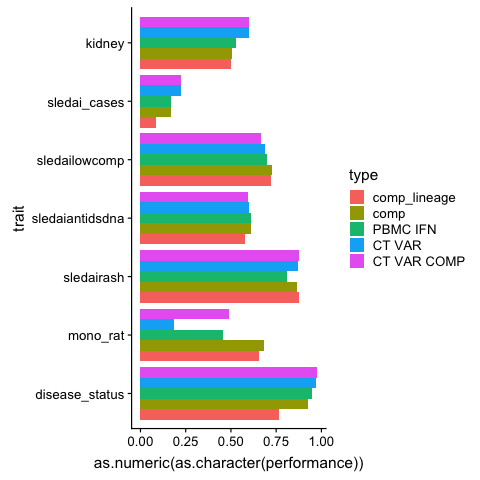

In [89]:
options(repr.plot.width = 6, repr.plot.height = 6, repr.plot.res=80)

df$performance <- as.numeric(as.character(df$performance));
df$type <- factor(df$type, levels=c("comp_lineage","comp", "PBMC IFN", "CT VAR", "CT VAR COMP"))
df$trait <- factor(df$trait, levels=c("disease_status","mono_rat", "sledairash", "sledaiantidsdna", "sledailowcomp", "sledai_cases", "kidney"))

ggplot(aes(x=trait, y=as.numeric(as.character(performance)), fill=type),data=df)+geom_bar(stat="identity",position=position_dodge())+coord_flip()
ggsave("performance_glmnet.png",height=6,width=6)

In [90]:
df

performance,type,trait
0.76374269,comp_lineage,disease_status
0.92511371,comp,disease_status
0.94943240,PBMC IFN,disease_status
0.97209227,CT VAR,disease_status
0.97651072,CT VAR COMP,disease_status
0.08856692,comp_lineage,sledai_cases
0.17036333,comp,sledai_cases
0.17081929,PBMC IFN,sledai_cases
0.22648803,CT VAR,sledai_cases
0.22560557,CT VAR COMP,sledai_cases


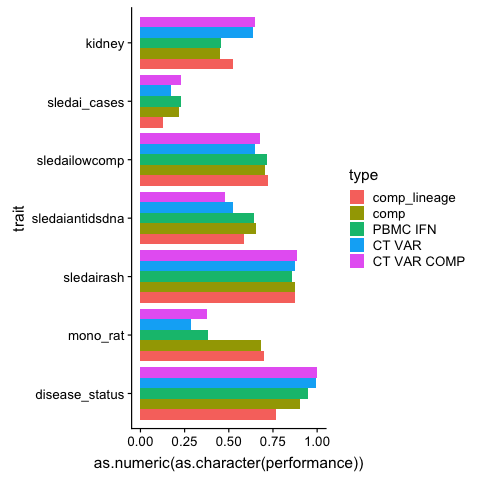

In [91]:
options(repr.plot.width = 6, repr.plot.height = 6, repr.plot.res=80)

df_svm$performance <- as.numeric(as.character(df_svm$performance));
df_svm$type <- factor(df_svm$type, levels=c("comp_lineage","comp", "PBMC IFN", "CT VAR", "CT VAR COMP"))
df_svm$trait <- factor(df_svm$trait, levels=c("disease_status","mono_rat", "sledairash", "sledaiantidsdna", "sledailowcomp", "sledai_cases", "kidney"))

ggplot(aes(x=trait, y=as.numeric(as.character(performance)), fill=type),data=df_svm)+geom_bar(stat="identity",position=position_dodge())+coord_flip()

In [92]:
joined_pivot$sle

NULL